# CS 584 - Natural Language Processing
## Final Project Code

Erika Deckter

In [49]:
#Import packages
import pandas as pd
import numpy as np
import math
from statistics import mean
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from tensorflow.keras import Input, Model, layers, optimizers, callbacks
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot, plot_model

In [2]:
reviews = pd.read_csv('data/reviews.txt', sep='|')

## Data Preparation

In [3]:
#Count total reviews by user and eliminate any users who have less than 10 reviews
keep_users = reviews.groupby('userID').count().sort_values(by='productID', ascending=False)
keep_users = keep_users[keep_users['productID']>=10]
filtered_reviews = reviews[reviews['userID'].isin(keep_users.index)]

In [4]:
#Count total products and eliminate products which have less than 10 reviews
keep_products = filtered_reviews.groupby('productID').count().sort_values(by='userID', ascending=False)
keep_products = keep_products[keep_products['userID']>=10]
filtered_reviews = filtered_reviews[filtered_reviews['productID'].isin(keep_products.index)]

In [5]:
product_list = filtered_reviews.groupby('productID').count().sort_values(by='userID', ascending=False).index

In [6]:
#Split products into training and test dataset
#Set random seed
np.random.seed = 42
training_products = np.random.choice(product_list, size=math.floor(len(product_list)*0.8), replace=False)

In [7]:
training_data = filtered_reviews[filtered_reviews['productID'].isin(training_products)]
test_data = filtered_reviews[~filtered_reviews['productID'].isin(training_products)]
#Show sizes
print('Total Number of Reviewed Products: {:,}'.format(len(product_list)))
print('Total Number of Reviewed Products in the Training Dataset: {:d}'.format(len(training_products)))
print('Size of Filtered Dataset: {:,}'.format(len(filtered_reviews)))
print('Size of Training Dataset: {:,}'.format(len(training_data)))
print('Size of Test Data: {:,}'.format(len(test_data)))

Total Number of Reviewed Products: 1,095
Total Number of Reviewed Products in the Training Dataset: 876
Size of Filtered Dataset: 37,642
Size of Training Dataset: 30,401
Size of Test Data: 7,241


In [8]:
#Get means and standard deviations for each user in the training dataset
review_counts = training_data[['userID','score']].groupby('userID').count().rename(columns={'score':'review_count'})
review_means = training_data[['userID','score']].groupby('userID').mean().rename(columns={'score':'review_mean'})
review_std = training_data[['userID','score']].groupby('userID').std().rename(columns={'score':'review_std'})
user_stats = (review_counts.join(review_means)).join(review_std)
#Change NaN in standard deviation to 1
#ASSUMPTION: For users whose review scores in the training data are all equal, set standard deviation to 1
#This will make the standardized score equal to actual score - mean score (i.e., 0 for training set)
user_stats['review_std'] = user_stats['review_std'].fillna(1)
user_stats['review_std'][user_stats['review_std']==0] = 1
#Join to training data
training_data = training_data.join(user_stats, on='userID', how='left')

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [9]:
#Calculate standardized scores for each review in training data
training_data['standard_score'] = (training_data['score'] - training_data['review_mean'])/training_data['review_std']

In [10]:
#Find minimum and maximum scores and normalize (to get scores from 0 to 1)
min_score = training_data['standard_score'].min()
max_score = training_data['standard_score'].max()

In [11]:
training_data['final_score'] = (training_data['standard_score'] - min_score)/(max_score - min_score)

Text(0.5, 1.0, 'Normalized Score Histogram for Training Dataset')

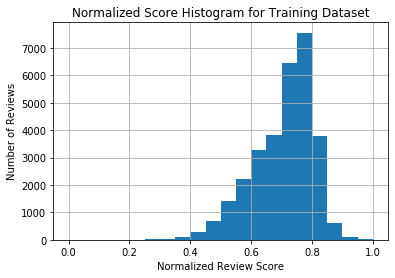

In [12]:
#Plot histogram of normalized scores
training_data['final_score'].hist(bins=20)
plt.xlabel('Normalized Review Score')
plt.ylabel('Number of Reviews')
plt.title('Normalized Score Histogram for Training Dataset')

In [13]:
#Calculate standardized scores for each review in test data (using training mean and standard deviation)
test_data = test_data.join(user_stats, on='userID', how='left')
#Remove reviews by users that have no reviews in the training dataset (1 review only)
test_data = test_data[~test_data['review_mean'].isna()]
test_data['standard_score'] = (test_data['score'] - test_data['review_mean'])/test_data['review_std']

In [14]:
#Calculate normalized scores for each review in the test data (using min and max from training dataset)
test_data['final_score'] = (test_data['standard_score'] - min_score)/(max_score - min_score)

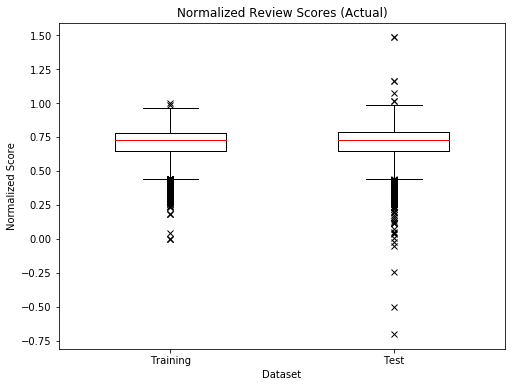

In [216]:
#Box and whisker plot for training and test normalized review scores
box_data = [training_data['final_score'], test_data['final_score']]

fig, ax = plt.subplots(figsize=(8, 6))
bp = ax.boxplot(box_data, widths=(0.5,0.5))
for median in bp['medians']:
    median.set(color='red', linewidth=1)
for flier in bp['fliers']:
    flier.set(marker='x', color='black')
ax.set_xticklabels(['Training','Test'])
plt.yticks(np.arange(-0.75,1.6,step=0.25))
plt.xlabel('Dataset')
plt.ylabel('Normalized Score')
plt.title('Normalized Review Scores (Actual)')
plt.show()

print('Training Normalized Score Mean {:.4f}'.format(training_data['final_score'].mean()))
print('Test Normalized Score Mean {:.4f}'.format(test_data['final_score'].mean()))

## Text Preparation

In [16]:
#Concatenate review summary and review text
training_data['reviews'] = training_data['summary']+' '+training_data['text']
test_data['reviews'] = test_data['summary']+' '+test_data['text']

In [17]:
#Create dictionary with 10,000 most common words in summaries and reviews
vocab_size = 10000
tokenizer = Tokenizer(num_words=vocab_size, split=' ',oov_token='<unk>', lower=True)
tokenizer.fit_on_texts(training_data['reviews'])

In [18]:
#Encode documents to integer tokens
training_data['tokens'] = tokenizer.texts_to_sequences(training_data['reviews'])
test_data['tokens'] = tokenizer.texts_to_sequences(test_data['reviews'])

In [19]:
review_lengths = [len(tokens) for tokens in training_data['tokens']]
print('Minimum length of review summary/text: {:d}'.format(min(review_lengths)))
print('Maximum length of review summary/text: {:d}'.format(max(review_lengths)))
print('Average length of review summary/text: {:.0f}'.format(mean(review_lengths)))

Minimum length of review summary/text: 5
Maximum length of review summary/text: 4422
Average length of review summary/text: 308


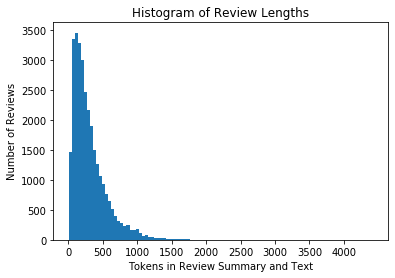

In [20]:
plt.hist(review_lengths, bins=100)
plt.xticks(np.arange(0,4001, step=500))
plt.xlabel('Tokens in Review Summary and Text')
plt.ylabel('Number of Reviews')
plt.title('Histogram of Review Lengths')
plt.show()

In [21]:
#Use zero padding to set all sequences to have length of 300 tokens
sequence_length = 300
train_x = np.array(pad_sequences(training_data['tokens'], padding='post', maxlen=sequence_length))
test_x = np.array(pad_sequences(test_data['tokens'], padding='post', maxlen=sequence_length))

In [22]:
#Assign output labels for model training
train_y = np.array(training_data['final_score'])
test_y = np.array(test_data['final_score'])

In [81]:
#Use TF-IDF to convert review summary/text into term frequency/document frequence matrix
tfidf = TfidfVectorizer(decode_error='ignore', lowercase=True, stop_words='english')
#Fit text data to TF-IDF matrix
tfidf.fit(training_data['reviews'])
#Convert text to TF-IDF matrix
train_tfidf = tfidf.transform(training_data['reviews'])
test_tfidf = tfidf.transform(test_data['reviews'])

## Modeling

### Linear Regression Model

In [24]:
#Linear regression to predict score based on TF-IDF features
lr_model = LinearRegression()
lr_model.fit(train_tfidf, train_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [25]:
#Calculate mean squared error
train_predictions = lr_model.predict(train_tfidf)
test_predictions = lr_model.predict(test_tfidf)
train_mse = mean_squared_error(train_y, train_predictions)
test_mse = mean_squared_error(test_y, test_predictions)
print('Baseline Model: Linear Regression')
print('Training Mean Squared Error: {:.6f}'.format(train_mse))
print('Test Mean Squared Error: {:.6f}'.format(test_mse))

Baseline Model: Linear Regression
Training Mean Squared Error: 0.000002
Test Mean Squared Error: 0.038603


### Recurrent Neural Network Model

In [26]:
#Define architecture of RNN model
def build_model(embedding_size=8, lstm_size=10):
    #Set up neural network architecture
    model_input = Input(shape=(sequence_length), name='model_input')
    #Embedding layer
    embedding = layers.Embedding(vocab_size+1, embedding_size, name='embedding')(model_input)
    #Bidirectional LSTM layer
    rnn = layers.Bidirectional(layers.LSTM(lstm_size, activation='tanh', dropout=0.5, recurrent_dropout=0.5),
                                   merge_mode='concat', name='bilstm')(embedding)
    #Create top layer to predict review score
    score = layers.Dense(1, activation='relu', name='output')(rnn)
    
    model = Model(inputs=model_input, outputs=score, name='review_scorer')
    
    return model

#Show architecture with default values for network size
build_model().summary()

Model: "review_scorer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_input (InputLayer)     [(None, 300)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 300, 8)            80008     
_________________________________________________________________
bilstm (Bidirectional)       (None, 20)                1520      
_________________________________________________________________
output (Dense)               (None, 1)                 21        
Total params: 81,549
Trainable params: 81,549
Non-trainable params: 0
_________________________________________________________________


In [29]:
#RNN hyperparameter tuning
embedding_sizes = [8, 16, 32]
lstm_sizes = [8, 16, 32]

histories = []
for embedding_size in embedding_sizes:
    for lstm_size in lstm_sizes:
        print('Embedding Size: ', embedding_size)
        print('LSTM Size: ', lstm_size)
        #Create new instance of RNN model
        rnn_model = build_model(embedding_size, lstm_size)
        #Compile new model
        rnn_model.compile(loss='mean_squared_error',
                          optimizer='rmsprop')
        #Train model using training dataset and the current hyperparameters
        history = rnn_model.fit(train_x, train_y, 
                                batch_size=32, 
                                epochs=20, 
                                validation_split=0.2)
        #Create new dictionary with loss weights, loss and val_loss
        history_dict = {'embedding_size': embedding_size, 'lstm_size': lstm_size}
        history_dict.update({k:v for k, v in history.history.items() if k in ['loss','val_loss']})
        #Save history loss and val_loss for future plotting
        histories.append(history_dict)

Embedding Size:  8
LSTM Size:  8
Train on 24320 samples, validate on 6081 samples
Epoch 1/20
24320/24320 [==============================] - 260s 11ms/sample - loss: 0.0240 - val_loss: 0.0091
Epoch 2/20
24320/24320 [==============================] - 252s 10ms/sample - loss: 0.0092 - val_loss: 0.0086
Epoch 3/20
24320/24320 [==============================] - 255s 10ms/sample - loss: 0.0087 - val_loss: 0.0084
Epoch 4/20
24320/24320 [==============================] - 253s 10ms/sample - loss: 0.0084 - val_loss: 0.0084
Epoch 5/20
24320/24320 [==============================] - 250s 10ms/sample - loss: 0.0082 - val_loss: 0.0084
Epoch 6/20
24320/24320 [==============================] - 242s 10ms/sample - loss: 0.0080 - val_loss: 0.0085
Epoch 7/20
24320/24320 [==============================] - 240s 10ms/sample - loss: 0.0078 - val_loss: 0.0084
Epoch 8/20
24320/24320 [==============================] - 241s 10ms/sample - loss: 0.0076 - val_loss: 0.0089
Epoch 9/20
24320/24320 [======================

24320/24320 [==============================] - 501s 21ms/sample - loss: 0.0065 - val_loss: 0.0082
Epoch 14/20
24320/24320 [==============================] - 503s 21ms/sample - loss: 0.0064 - val_loss: 0.0083
Epoch 15/20
24320/24320 [==============================] - 497s 20ms/sample - loss: 0.0063 - val_loss: 0.0081
Epoch 16/20
24320/24320 [==============================] - 399s 16ms/sample - loss: 0.0062 - val_loss: 0.0081
Epoch 17/20
24320/24320 [==============================] - 379s 16ms/sample - loss: 0.0062 - val_loss: 0.0081
Epoch 18/20
24320/24320 [==============================] - 375s 15ms/sample - loss: 0.0061 - val_loss: 0.0082
Epoch 19/20
24320/24320 [==============================] - 384s 16ms/sample - loss: 0.0060 - val_loss: 0.0084
Epoch 20/20
24320/24320 [==============================] - 384s 16ms/sample - loss: 0.0059 - val_loss: 0.0081
Embedding Size:  16
LSTM Size:  16
Train on 24320 samples, validate on 6081 samples
Epoch 1/20
24320/24320 [========================

Epoch 5/20
24320/24320 [==============================] - 368s 15ms/sample - loss: 0.0077 - val_loss: 0.0083
Epoch 6/20
24320/24320 [==============================] - 368s 15ms/sample - loss: 0.0074 - val_loss: 0.0084
Epoch 7/20
24320/24320 [==============================] - 367s 15ms/sample - loss: 0.0071 - val_loss: 0.0084
Epoch 8/20
24320/24320 [==============================] - 367s 15ms/sample - loss: 0.0068 - val_loss: 0.0082
Epoch 9/20
24320/24320 [==============================] - 368s 15ms/sample - loss: 0.0066 - val_loss: 0.0081
Epoch 10/20
24320/24320 [==============================] - 368s 15ms/sample - loss: 0.0064 - val_loss: 0.0081
Epoch 11/20
24320/24320 [==============================] - 368s 15ms/sample - loss: 0.0062 - val_loss: 0.0082
Epoch 12/20
24320/24320 [==============================] - 368s 15ms/sample - loss: 0.0061 - val_loss: 0.0081
Epoch 13/20
24320/24320 [==============================] - 368s 15ms/sample - loss: 0.0059 - val_loss: 0.0082
Epoch 14/20
243

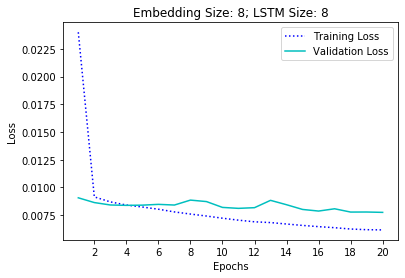

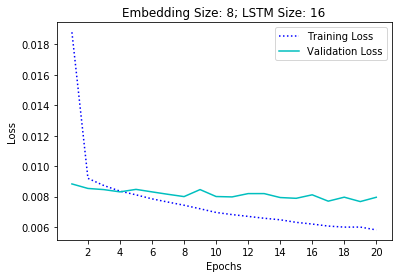

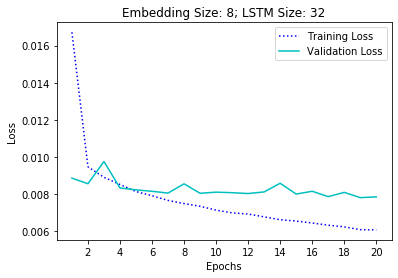

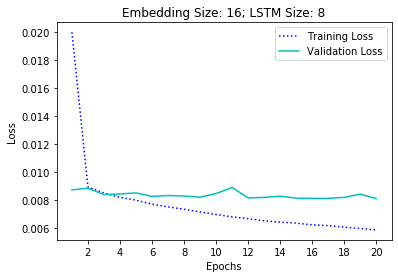

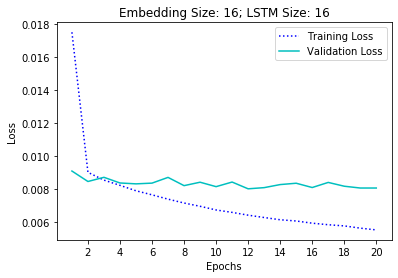

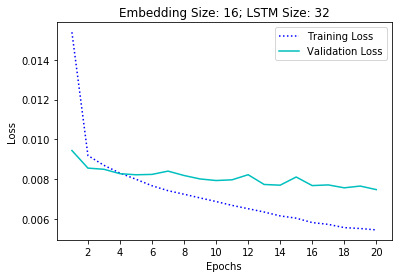

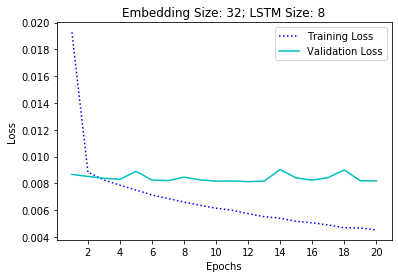

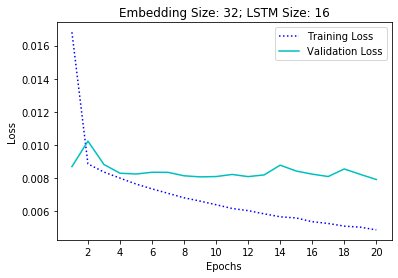

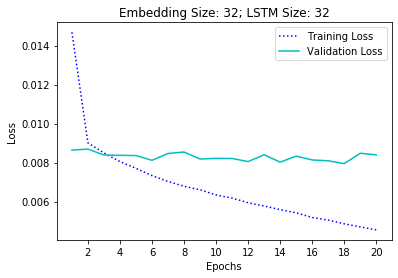

In [30]:
#Plot losses for each combination of loss weights
for history in histories:    
    #Plot training and validation losses
    loss = history['loss']
    val_loss = history['val_loss']

    epochs = np.arange(1,len(loss) + 1)

    plt.plot(epochs, loss, 'b:', label='Training Loss')
    plt.plot(epochs, val_loss, 'c-', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xticks([2,4,6,8,10,12,14,16,18,20])
    plt.title('Embedding Size: {:d}; LSTM Size: {:d}'.format(history['embedding_size'], history['lstm_size']))
    plt.legend()
    plt.show()

In [31]:
#Train final RNN model with best hyperparameters
embedding_size = 16
lstm_size = 32

rnn_model = build_model(embedding_size, lstm_size)
print(rnn_model.summary())

#Compile new model
rnn_model.compile(loss='mean_squared_error',
                  optimizer='rmsprop')

#Train model using training dataset and the current learning rate
history = rnn_model.fit(train_x, train_y, 
                        batch_size=32, 
                        epochs=20)

#Save final model
rnn_model.save('review_scorer.h5')

Model: "review_scorer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_input (InputLayer)     [(None, 300)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 300, 16)           160016    
_________________________________________________________________
bilstm (Bidirectional)       (None, 64)                12544     
_________________________________________________________________
output (Dense)               (None, 1)                 65        
Total params: 172,625
Trainable params: 172,625
Non-trainable params: 0
_________________________________________________________________
None
Train on 30401 samples
Epoch 1/20
30401/30401 [==============================] - 734s 24ms/sample - loss: 0.0142
Epoch 2/20
30401/30401 [==============================] - 673s 22ms/sample - loss: 0.0090
Epoch 3/20
30401/30401 [=============

In [36]:
#Calculate mean squared error for final RNN model
train_predictions = rnn_model.predict(train_x)
test_predictions = rnn_model.predict(test_x)
train_mse = mean_squared_error(train_y, train_predictions)
test_mse = mean_squared_error(test_y, test_predictions)
print('RNN Model')
print('Training Mean Squared Error: {:.6f}'.format(train_mse))
print('Test Mean Squared Error: {:.6f}'.format(test_mse))

RNN Model
Training Mean Squared Error: 0.004345
Test Mean Squared Error: 0.009882


### Convolutional Neural Network Model

In [37]:
#1D Convolution model
#Define architecture of CNN model
def build_model(embedding_size=16, filters=10, kernel_size=7):
    #Set up neural network architecture
    model_input = Input(shape=(sequence_length), name='model_input')
    #Embedding layer
    embedding = layers.Embedding(vocab_size+1, embedding_size, name='embedding')(model_input)
    #1D Convolution Layer
    cnn = layers.Conv1D(filters, kernel_size, padding='same', name='Conv1D')(embedding)
    #Global Max Pooling Layer
    max_pool = layers.GlobalMaxPooling1D(name='max_pool')(cnn)
    #Create top layer to predict review score
    score = layers.Dense(1, activation='relu', name='output')(max_pool)
    
    model = Model(inputs=model_input, outputs=score, name='cnn_scorer')
    
    return model

#Show architecture with default values for network size
build_model().summary()

Model: "cnn_scorer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_input (InputLayer)     [(None, 300)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 300, 16)           160016    
_________________________________________________________________
Conv1D (Conv1D)              (None, 300, 10)           1130      
_________________________________________________________________
max_pool (GlobalMaxPooling1D (None, 10)                0         
_________________________________________________________________
output (Dense)               (None, 1)                 11        
Total params: 161,157
Trainable params: 161,157
Non-trainable params: 0
_________________________________________________________________


In [39]:
#CNN hyperparameter tuning
embedding_sizes = [8, 16, 32]
filters = [5, 10, 15]
kernel_sizes = [5, 7, 9, 11]

histories = []
for embedding_size in embedding_sizes:
    for f in filters:
        for kernel_size in kernel_sizes:
            print('Embedding Size: ', embedding_size)
            print('Filter Count: ', f)
            print('Filter Size: ', kernel_size)
            #Create new instance of CNN model
            cnn_model = build_model(embedding_size, f, kernel_size)
            #Compile new model
            cnn_model.compile(loss='mean_squared_error',
                              optimizer='rmsprop')
            #Train model using training dataset and the current hyperparameters
            history = cnn_model.fit(train_x, train_y, 
                                    batch_size=32, 
                                    epochs=20, 
                                    validation_split=0.2)
            #Create new dictionary with loss weights, loss and val_loss
            history_dict = {'embedding_size': embedding_size, 'filters': f, 'kernel_size': kernel_size}
            history_dict.update({k:v for k, v in history.history.items() if k in ['loss','val_loss']})
            #Save history loss and val_loss for future plotting
            histories.append(history_dict)

Embedding Size:  8
Filter Count:  5
Filter Size:  5
Train on 24320 samples, validate on 6081 samples
Epoch 1/20
24320/24320 [==============================] - 36s 1ms/sample - loss: 0.0251 - val_loss: 0.0089- loss - ETA: 2s - loss: 0.
Epoch 2/20
24320/24320 [==============================] - 35s 1ms/sample - loss: 0.0077 - val_loss: 0.0085
Epoch 3/20
24320/24320 [==============================] - 36s 1ms/sample - loss: 0.0066 - val_loss: 0.0085 loss
Epoch 4/20
24320/24320 [==============================] - 36s 1ms/sample - loss: 0.0058 - val_loss: 0.0088 loss:
Epoch 5/20
24320/24320 [==============================] - 34s 1ms/sample - loss: 0.0052 - val_loss: 0.0089
Epoch 6/20
24320/24320 [==============================] - 29s 1ms/sample - loss: 0.0046 - val_loss: 0.0091
Epoch 7/20
24320/24320 [==============================] - 34s 1ms/sample - loss: 0.0042 - val_loss: 0.0094
Epoch 8/20
24320/24320 [==============================] - 34s 1ms/sample - loss: 0.0038 - val_loss: 0.0096
Epoch

24320/24320 [==============================] - 45s 2ms/sample - loss: 0.0010 - val_loss: 0.0104
Embedding Size:  8
Filter Count:  10
Filter Size:  11
Train on 24320 samples, validate on 6081 samples
Epoch 1/20
24320/24320 [==============================] - 56s 2ms/sample - loss: 0.5058 - val_loss: 0.5126
Epoch 2/20
24320/24320 [==============================] - 56s 2ms/sample - loss: 0.5058 - val_loss: 0.5126
Epoch 3/20
24320/24320 [==============================] - 55s 2ms/sample - loss: 0.5058 - val_loss: 0.5126
Epoch 4/20
24320/24320 [==============================] - 56s 2ms/sample - loss: 0.5058 - val_loss: 0.5126
Epoch 5/20
24320/24320 [==============================] - 54s 2ms/sample - loss: 0.5058 - val_loss: 0.5126
Epoch 6/20
24320/24320 [==============================] - 52s 2ms/sample - loss: 0.5058 - val_loss: 0.5126
Epoch 7/20
24320/24320 [==============================] - 54s 2ms/sample - loss: 0.5058 - val_loss: 0.5126
Epoch 8/20
24320/24320 [============================

24320/24320 [==============================] - 34s 1ms/sample - loss: 0.0081 - val_loss: 0.0087
Epoch 3/20
24320/24320 [==============================] - 34s 1ms/sample - loss: 0.0063 - val_loss: 0.0087
Epoch 4/20
24320/24320 [==============================] - 34s 1ms/sample - loss: 0.0050 - val_loss: 0.0089
Epoch 5/20
24320/24320 [==============================] - 34s 1ms/sample - loss: 0.0040 - val_loss: 0.0090
Epoch 6/20
24320/24320 [==============================] - 34s 1ms/sample - loss: 0.0033 - val_loss: 0.0094
Epoch 7/20
24320/24320 [==============================] - 34s 1ms/sample - loss: 0.0028 - val_loss: 0.0096
Epoch 8/20
24320/24320 [==============================] - 34s 1ms/sample - loss: 0.0024 - val_loss: 0.0097
Epoch 9/20
24320/24320 [==============================] - 35s 1ms/sample - loss: 0.0021 - val_loss: 0.0099
Epoch 10/20
24320/24320 [==============================] - 34s 1ms/sample - loss: 0.0018 - val_loss: 0.0104
Epoch 11/20
24320/24320 [======================

Epoch 6/20
24320/24320 [==============================] - 59s 2ms/sample - loss: 0.5058 - val_loss: 0.5126
Epoch 7/20
24320/24320 [==============================] - 59s 2ms/sample - loss: 0.5058 - val_loss: 0.5126
Epoch 8/20
24320/24320 [==============================] - 60s 2ms/sample - loss: 0.5058 - val_loss: 0.5126
Epoch 9/20
24320/24320 [==============================] - 59s 2ms/sample - loss: 0.5058 - val_loss: 0.5126
Epoch 10/20
24320/24320 [==============================] - 58s 2ms/sample - loss: 0.5058 - val_loss: 0.5126
Epoch 11/20
24320/24320 [==============================] - 60s 2ms/sample - loss: 0.5058 - val_loss: 0.5126
Epoch 12/20
24320/24320 [==============================] - 58s 2ms/sample - loss: 0.5058 - val_loss: 0.5126
Epoch 13/20
24320/24320 [==============================] - 58s 2ms/sample - loss: 0.5058 - val_loss: 0.5126
Epoch 14/20
24320/24320 [==============================] - 56s 2ms/sample - loss: 0.5058 - val_loss: 0.5126
Epoch 15/20
24320/24320 [=======

24320/24320 [==============================] - 39s 2ms/sample - loss: 0.0027 - val_loss: 0.0092
Epoch 7/20
24320/24320 [==============================] - 38s 2ms/sample - loss: 0.0023 - val_loss: 0.0093
Epoch 8/20
24320/24320 [==============================] - 39s 2ms/sample - loss: 0.0020 - val_loss: 0.0096
Epoch 9/20
24320/24320 [==============================] - 39s 2ms/sample - loss: 0.0017 - val_loss: 0.0098
Epoch 10/20
24320/24320 [==============================] - 39s 2ms/sample - loss: 0.0015 - val_loss: 0.0098
Epoch 11/20
24320/24320 [==============================] - 39s 2ms/sample - loss: 0.0014 - val_loss: 0.0105
Epoch 12/20
24320/24320 [==============================] - 39s 2ms/sample - loss: 0.0013 - val_loss: 0.0099
Epoch 13/20
24320/24320 [==============================] - 39s 2ms/sample - loss: 0.0011 - val_loss: 0.0101
Epoch 14/20
24320/24320 [==============================] - 38s 2ms/sample - loss: 0.0011 - val_loss: 0.0101
Epoch 15/20
24320/24320 [==================

24320/24320 [==============================] - 83s 3ms/sample - loss: 0.5058 - val_loss: 0.5126
Epoch 9/20
24320/24320 [==============================] - 83s 3ms/sample - loss: 0.5058 - val_loss: 0.5126
Epoch 10/20
24320/24320 [==============================] - 83s 3ms/sample - loss: 0.5058 - val_loss: 0.5126
Epoch 11/20
24320/24320 [==============================] - 82s 3ms/sample - loss: 0.5058 - val_loss: 0.5126
Epoch 12/20
24320/24320 [==============================] - 83s 3ms/sample - loss: 0.5058 - val_loss: 0.5126
Epoch 13/20
24320/24320 [==============================] - 83s 3ms/sample - loss: 0.5058 - val_loss: 0.5126
Epoch 14/20
24320/24320 [==============================] - 83s 3ms/sample - loss: 0.5058 - val_loss: 0.5126
Epoch 15/20
24320/24320 [==============================] - 83s 3ms/sample - loss: 0.5058 - val_loss: 0.5126
Epoch 16/20
24320/24320 [==============================] - 83s 3ms/sample - loss: 0.5058 - val_loss: 0.5126
Epoch 17/20
24320/24320 [================

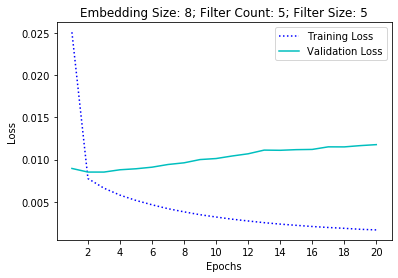

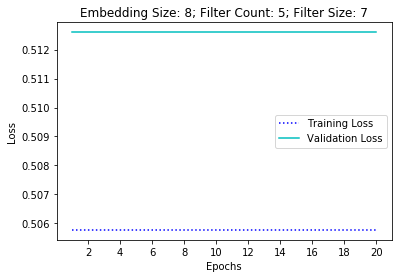

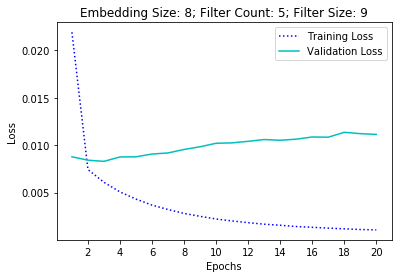

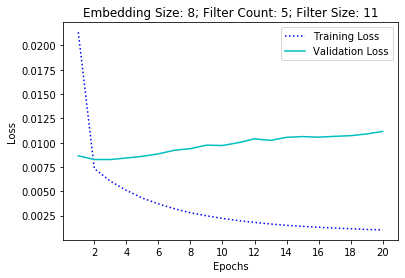

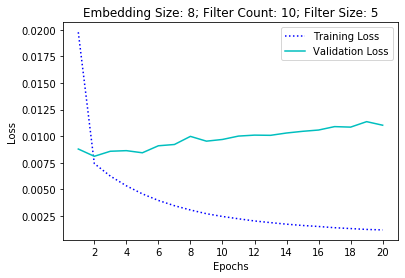

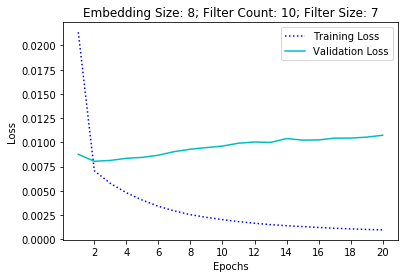

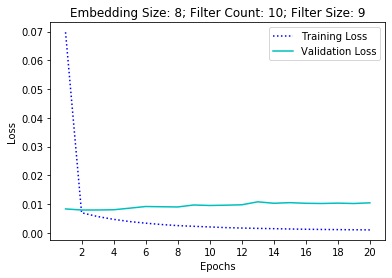

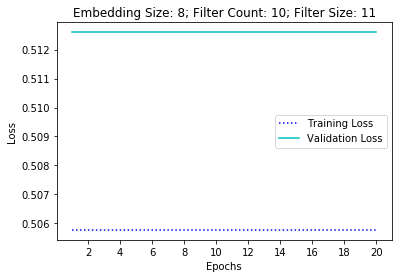

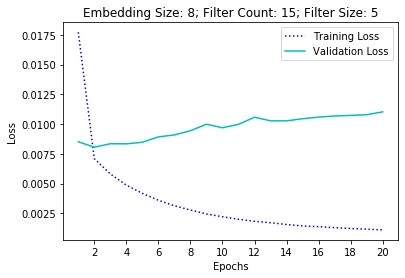

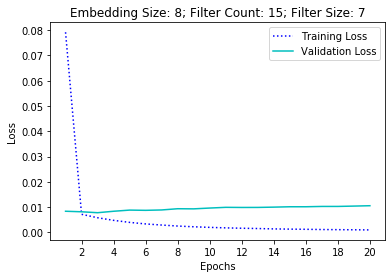

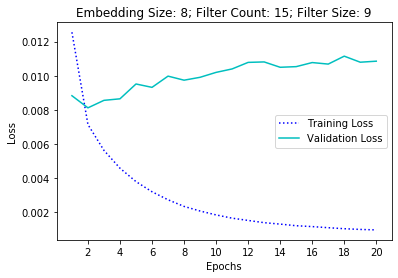

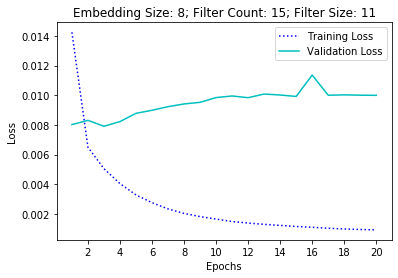

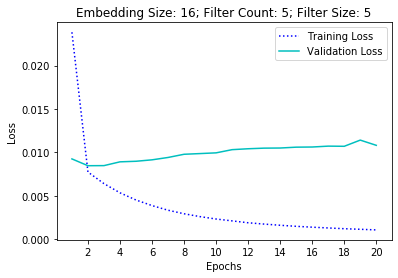

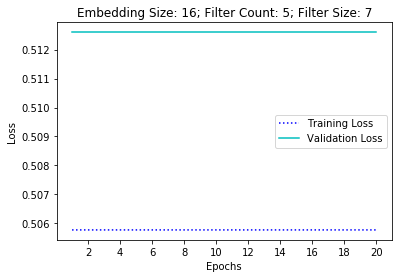

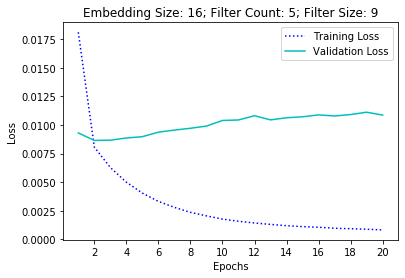

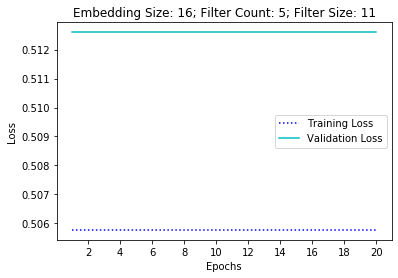

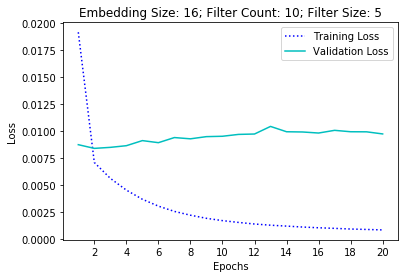

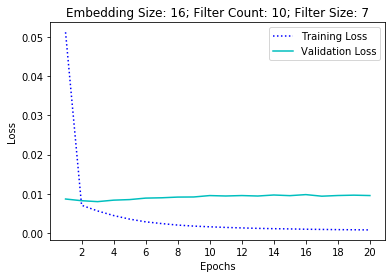

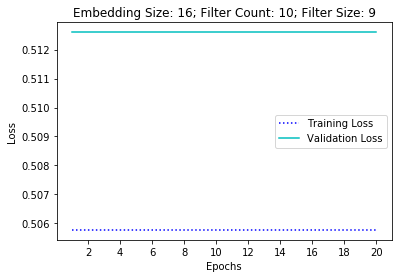

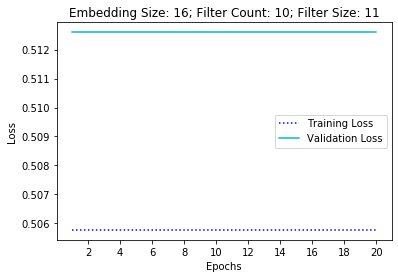

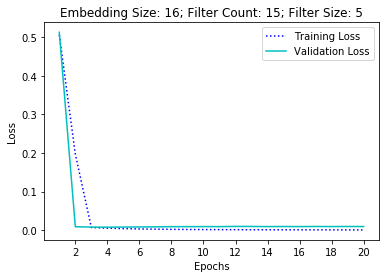

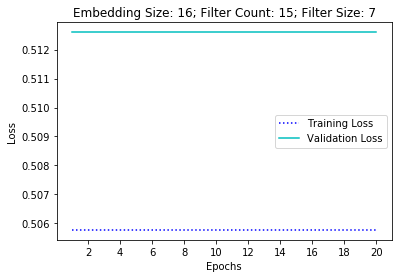

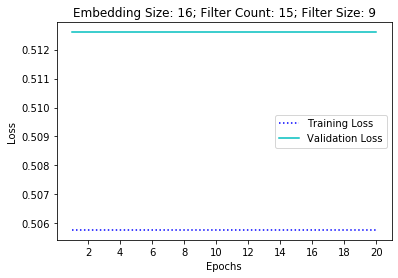

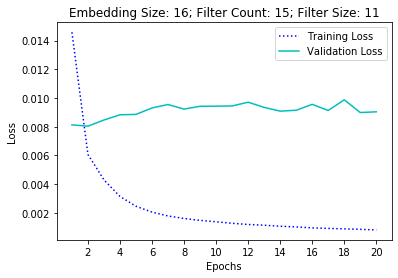

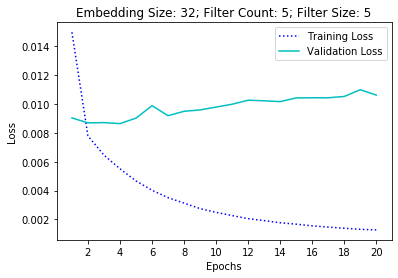

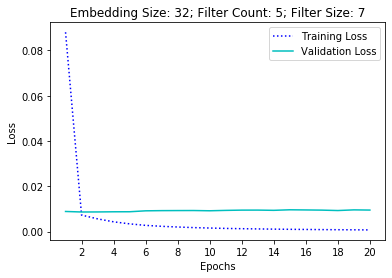

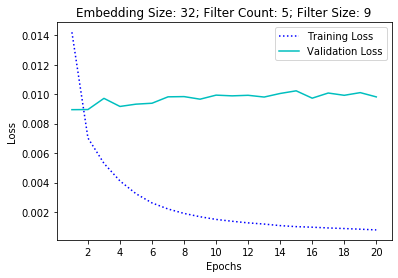

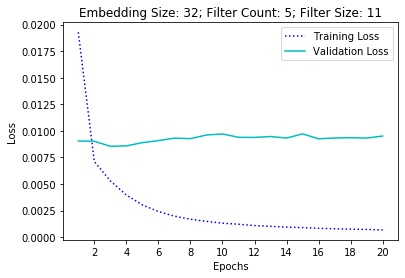

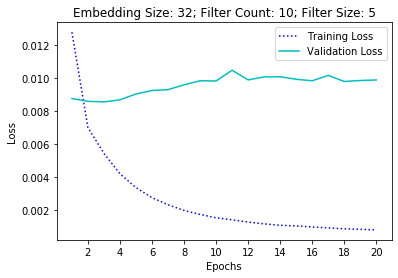

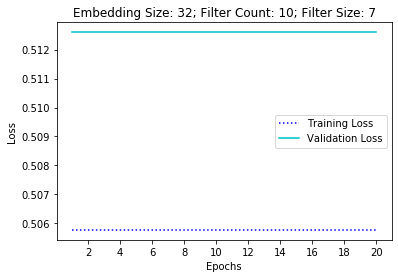

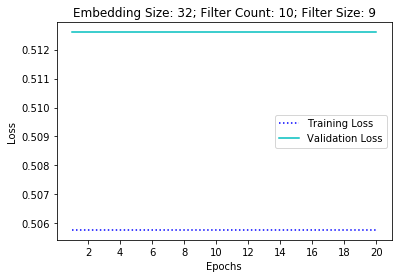

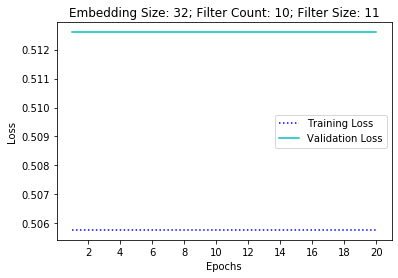

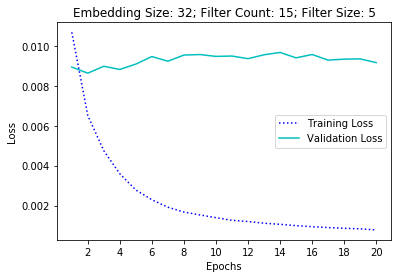

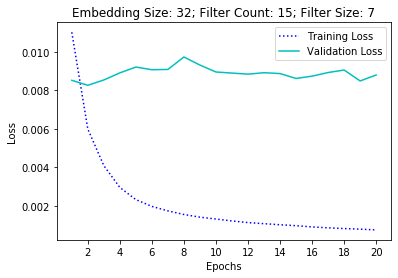

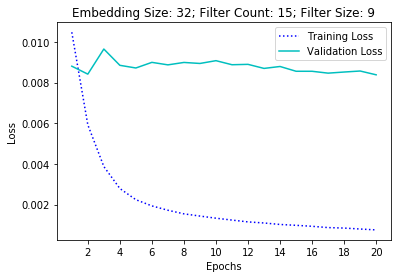

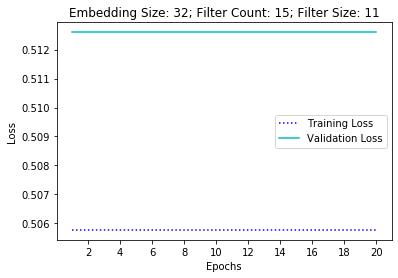

In [40]:
#Plot losses for each combination of loss weights
for history in histories:    
    #Plot training and validation losses
    loss = history['loss']
    val_loss = history['val_loss']

    epochs = np.arange(1,len(loss) + 1)

    plt.plot(epochs, loss, 'b:', label='Training Loss')
    plt.plot(epochs, val_loss, 'c-', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xticks([2,4,6,8,10,12,14,16,18,20])
    plt.title('Embedding Size: {:d}; Filter Count: {:d}; Filter Size: {:d}'.format(history['embedding_size'], history['filters'], history['kernel_size']))
    plt.legend()
    plt.show()

In [58]:
#Train final CNN model with full training data set
embedding_size = 16
filters = 10
kernel_size = 5

#Create new instance of CNN model
cnn_model = build_model(embedding_size, f, kernel_size)
#Compile new model
cnn_model.compile(loss='mean_squared_error',
                  optimizer='rmsprop')
#Train model using training dataset and the current hyperparameters
history = cnn_model.fit(train_x, train_y, 
                        batch_size=32, 
                        epochs=3)

#Save final model
cnn_model.save('cnn_scorer.h5')

Train on 30401 samples
Epoch 1/3
30401/30401 [==============================] - 67s 2ms/sample - loss: 0.0127
Epoch 2/3
30401/30401 [==============================] - 67s 2ms/sample - loss: 0.0069
Epoch 3/3
30401/30401 [==============================] - 67s 2ms/sample - loss: 0.0055


In [60]:
#Calculate mean squared error for final CNN model
train_predictions = cnn_model.predict(train_x)
test_predictions = cnn_model.predict(test_x)
train_mse = mean_squared_error(train_y, train_predictions)
test_mse = mean_squared_error(test_y, test_predictions)
print('CNN Model')
print('Training Mean Squared Error: {:.6f}'.format(train_mse))
print('Test Mean Squared Error: {:.6f}'.format(test_mse))

CNN Model
Training Mean Squared Error: 0.005601
Test Mean Squared Error: 0.012431


RNN Architecture


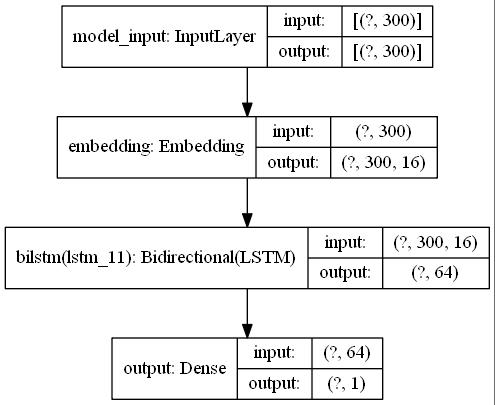

In [53]:
#Create architecture diagrams of final RNN model (for report)
SVG(model_to_dot(rnn_model, show_shapes=True).create(prog='dot', format='svg'))
print('RNN Architecture')
plot_model(model=rnn_model, show_shapes=True, to_file='rnn_model.jpg')

CNN Architecture


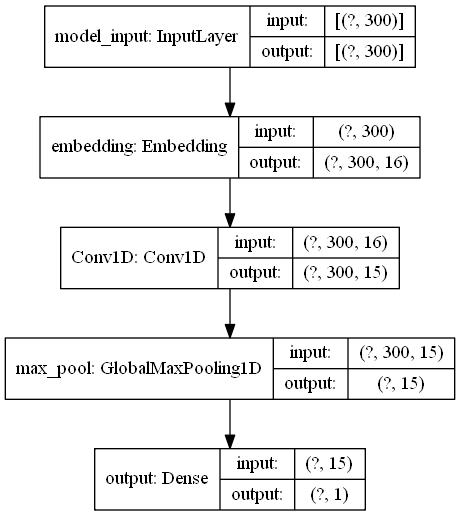

In [61]:
#Create architecture diagrams of final CNN model (for report)
SVG(model_to_dot(cnn_model, show_shapes=True).create(prog='dot', format='svg'))
print('CNN Architecture')
plot_model(model=cnn_model, show_shapes=True, to_file='cnn_model.jpg')

## Aggregated Review Score

In [67]:
#Create aggregated review scores for test dataset
test_results = test_data[['productID','final_score']].copy()
test_results['lr_score'] = lr_model.predict(test_tfidf)
test_results['rnn_score'] = rnn_model.predict(test_x)
test_results['cnn_score'] = cnn_model.predict(test_x)

In [70]:
aggregate_scores = test_results.groupby('productID').mean()

In [71]:
lr_mse = mean_squared_error(aggregate_scores['final_score'],aggregate_scores['lr_score'])
rnn_mse = mean_squared_error(aggregate_scores['final_score'],aggregate_scores['rnn_score'])
cnn_mse = mean_squared_error(aggregate_scores['final_score'],aggregate_scores['cnn_score'])
print('Test Aggregated Score MSE for Linear Regression: {:.6f}'.format(lr_mse))
print('Test Aggregated Score MSE for RNN: {:.6f}'.format(rnn_mse))
print('Test Aggregated Score MSE for CNN: {:.6f}'.format(cnn_mse))

Test Aggregated Score MSE for Linear Regression: 0.008386
Test Aggregated Score MSE for RNN: 0.001283
Test Aggregated Score MSE for CNN: 0.003124


# Test Out of Sample Movie Reviews

In [108]:
#Read in test reviews
test_reviews = pd.read_excel('data/test_reviews.xlsx', tab='test_reviews')
test_reviews.head()

,Film_ID,Publication,Author,Headline,Text,RT Sentiment,Score
0,1,New York Times,A.O. Scott,‘Joker’ Review: Are You Kidding Me?,Since its debut a few weeks ago at the Venice ...,0,NaN
1,1,New Yorker,Richard Brody,"“Joker” Is a Viewing Experience of Rare, Numbi...",Long before “Joker” pays homage to two of the ...,0,NaN
2,1,Slate,Dana Stevens,The Real Reason to Skip Joker Is That It’s Boring,“I hope my death will make more cents than my...,0,NaN
3,1,Rolling Stone,Peter Travers,‘Joker’ Review: Joaquin Phoenix’s Joker Is Ind...,"For the first time, the man who laughs gets th...",1,0.900
4,1,Chicago Sun-Times,Richard Roeper,"First-class clown: ‘Joker’ a chilling, absorbi...",It’s difficult to fathom anyone who has actual...,1,0.875


In [109]:
#Data Preprocessing
#Concatenate headline and text
test_reviews['review'] = test_reviews['Headline']+' '+test_reviews['Text']

#Transform text into TF-IDF matrix
review_tfidf = tfidf.transform(test_reviews['review'])

#Tokenize text and convert to 300 word sequences
tokens = tokenizer.texts_to_sequences(test_reviews['review'])
sequences = np.array(pad_sequences(tokens, padding='post', maxlen=sequence_length))

In [110]:
#Predict scores from all three models including headlines
test_reviews['lr_score'] = lr_model.predict(review_tfidf)
test_reviews['rnn_score'] = rnn_model.predict(sequences)
test_reviews['cnn_score'] = cnn_model.predict(sequences)

In [111]:
#Repeat predictions without using headlines
#Transform text into TF-IDF matrix
review_tfidf = tfidf.transform(test_reviews['Text'])

#Tokenize text and convert to 300 word sequences
tokens = tokenizer.texts_to_sequences(test_reviews['Text'])
sequences = np.array(pad_sequences(tokens, padding='post', maxlen=sequence_length))

In [112]:
#Predict scores from all three models excluding headlines
test_reviews['lr_score_noHL'] = lr_model.predict(review_tfidf)
test_reviews['rnn_score_noHL'] = rnn_model.predict(sequences)
test_reviews['cnn_score_noHL'] = cnn_model.predict(sequences)

In [113]:
#Aggregate scores
aggregates = test_reviews[['Film_ID','RT Sentiment','lr_score','rnn_score','cnn_score','lr_score_noHL','rnn_score_noHL','cnn_score_noHL']].groupby('Film_ID').mean()
aggregates

,RT Sentiment,lr_score,rnn_score,cnn_score,lr_score_noHL,rnn_score_noHL,cnn_score_noHL
Film_ID,,,,,,,
1,0.5,0.709522,0.690547,0.620758,0.725738,0.690547,0.620758
2,0.5,0.598574,0.684972,0.631809,0.609921,0.678210,0.631410
3,1.0,0.701805,0.712545,0.661349,0.706863,0.712545,0.661349
4,0.0,0.637008,0.654292,0.659592,0.645333,0.660617,0.667137


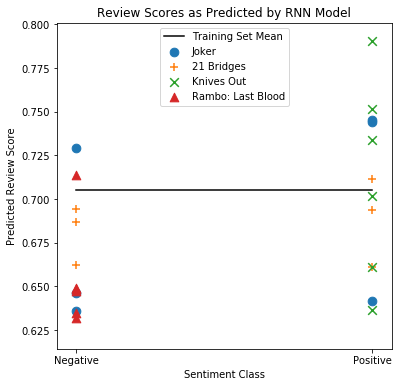

In [214]:
#Plot individual review scores
markers = ['v','o','+','x','^']
fig, ax = plt.subplots(figsize=(6, 6))
for i, reviews in test_reviews.groupby('Film_ID'):
    ax.scatter(reviews['RT Sentiment'], reviews['rnn_score'], s=75, marker=markers[i], label='Movie {:d}'.format(i))
ax.plot(np.arange(0,1.1,step=1),[0.705,0.705], color='black')
plt.xticks([0,1],['Negative','Positive'])
plt.xlabel('Sentiment Class')
plt.ylabel('Predicted Review Score')
plt.title('Review Scores as Predicted by RNN Model')
plt.legend(['Training Set Mean','Joker','21 Bridges','Knives Out','Rambo: Last Blood'],loc='upper center')
plt.show()